# Demo: Baby Example with Hamiltonian Monte Carlo

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')

In this demo we investigate the **Hamiltonian Monte Carlo (HMC)** method, a clever sampling technique that improves upon the random-walk-centric Metropolis-Hastings algorithm we have already discussed. The "why" of HMC relies on some facility with classical statistical mechanics, so the demo begins with a bare-bones introduction to this topics; more complete discussion is relegated to the references. Once we have the basics of stat mech under control, we can introduce HMC and dive right into seeing how it can be used to sample a normal distribution. We'll treat more complicated and interesting distributions in future demos. 

## Suggested References

- Oliver Buhler, *A Brief Introduction to Classical, Statistical, and Quantum Mechanics*, AMS Courant Lecture Notes Series, 2006

- Tony Chan and Jianhong Shen, *Image Processing and Analysis: Variational, PDE, Wavelet, and Stochastic Methods*, SIAM, 2005

- Charles Kittel, *Elementary Statistical Physics*, Dover, 2012 (reprint of the 1958 edition) 

- Radford Neal, "MCMC using Hamiltonian Dynamics", Ch. 5 of *Handbook of Markov Chain Monte Carlo*, editted by Brooks et al., Chapman & Hall/CRC, 2011, http://www.mcmchandbook.net/HandbookChapter5.pdf (most of our discussion is based off this source)

## Essentials of Statistical Mechanics

### Basic Goals & Objects of the Theory

Consider a system of $N$ non-interacting classical particles occupying a certain subregion of physical space. We allow the particles to possibly have different masses. Let the position of the $k^{\text{th}}$ particle be denoted by $q_{k}(t)$, and let its momentum be denoted by $p_{k}(t)$. For brevity, we abbreviate the state of the system at time $t$ by 
$$
x(t) = \left(q_{1}(t), ... ,q_{N}(t), p_{1}(t), ..., p_{N}(t)\right). 
$$
Suppose that, due to certain mechanical constraints and/or the effect of an external potential $U(q_{1},...,q_{N})$, the state of the system at any given time must occupy a particular subset 
$$ \Omega \subseteq \mathbb{R}^{2N} $$
of phase space.

Finally, recall that, if $H(x)$ denotes the total energy of the system, then **Hamilton's canonical equations** are satisfied:
\begin{align*}
\dot{q}_{k} &= \phantom{-}\frac{\partial H}{\partial p_{k}}, \quad \forall \ k, \quad \text{and}
\\
\dot{p}_{k} &= -\frac{\partial H}{\partial q_{k}}, \quad \forall \ k. 
\end{align*}
By solving Hamilton's equations with a particular set of initial conditions, we can determine the state of our system for all times. 

Here comes a problem: if $N\gg 1$, then determining appropriate initial conditions may be extrememly difficult. For example, there is no easy way to measure the position and momentum of *all* the air molecules in a room with absolute certainty (even if we lived in a non-quantum universe). So, for large $N$, solving the canonical equations is not a practical way to make sensible physical predictions about our system. 

Instead of solving Hamilton's equations precisely, we may view the system as *microscopic*, and accept that we can only really observe it at a coarse *macroscopic* scale. This means we give up an enormous amount of information about the particular state our system occupies, so how can we hope to make useful predictions? We turn to probability theory, the music of lost information. By looking at the statistical behaviour of a large ensemble of particular microscopic states that could reasonably describe our system, we can obtain good physics that is at least valid on our real-world macroscopic scale. There is no better name for this approach than **statistical mechanics**. 

We start with a bit of vocabulary that helps make some of the above discussion more precise. First, we use the term *microstate* to mean the actual state of our system at the microscopic scale. Similarly, the term *macrostate* refers to all the information available to us at the macroscopic laboratory scale. A microstate is described by the usual canonical variables $x$, but a macrostate is described on thermodynamic variables like total volume occupied by the system in physical space and temperature. So, we can summarize the motivation behind statistical mechanics by saying that microstates are impssible to determine precisely, and we must be content with handling macrostates alone. Likewise, we can summarize the main idea of statistical mechanics by saying that doing statistics on "ensembles" of microstates can help us say something about a given macrostate!

Next, we should clarify what we mean by an "ensemble". An ensemble is a rule for assigning any set of microstates $\Omega'\subseteq \Omega$ with a probability $\mu\left(\Omega'\right)\in [0,1]$ reflecting that chances that those microstates give rise to the macrostate we actually observe. Mathematically speaking, an ensemble gives a probability measure $\mathrm{d} \mu$ defined on, say, the Borel $\sigma$-algebra of $\Omega$. We always assume this probability measure admits a *probability distribution* $\rho(x)$: if $\mathrm{d}x$ denotes Lebesgue measure on $\mathbb{R}^{2N}$, then
$$
\mathrm{d} \mu = \rho(x) \ \mathrm{d}x. 
$$
If $\rho(x)\approx 1$ for $x\in \Omega'$, then we can say it's very likely that the macrostate we observe corresponds to one of the microstates in $\Omega'$. Conversely, if $\rho(x)\ll 1$ for $x\in \Omega'$, then it is highly unlikely (but not impossible) that the microstate that underlies our macrostate lives in $\Omega'$. For a more old-fashioned but perhaps more insightful discussion on the zen meaning of an ensemble, see $\S 2$ of Kittel. 

Finally, we define what we mean by using the "statistical behaviour" of an ensemble to make predictions about our macrostate. This is very simple: once we have our probability distribution function $\rho(x)$, we can use it to compute the expectation, variance, and other statistics associated to a microstate function such as the Hamiltonian $H(x)$. This is a corollary of the tautological observation that every microstate function becomes a random variable once we equip $\Omega$ with a probability measure. From the way $\rho(x)$ has been defined, the expectation of the Hamiltonian, denoted $\left\langle H\right\rangle$, should correspond to the macroscopically observed total energy of our system $H_0$:
$$
H_0 = \left\langle H\right\rangle = \int_{\Omega} H(x) \ \rho(x)\  \mathrm{d} x. 
$$
The general idea should now be clear: the macroscopically observable value of a particular quantity is the expectation of the corresponding quantity when viewed as a function on microstates. Thus statistical mechanics uses the tools of probability to make tangible, macro-world sense by performing statistical computations in the micro-world. 

A remark on nomenclature: in physics books, $\left\langle H\right\rangle$ is explicitly referred to as the **ensemble average** to distinguish it from the time average that appears when studying ergodic properties of mechanical systems. 

### Obtaining $\rho(x)$ via Entropy Maximization

All of the above discussion seems fine and dandy, but there is one major issue: how can we actually determine the correct probability density $\rho(x)$ applicable to our system? Once we have this density we're good to go, but guessing the correct $\rho(x)$ does not seem easy. Certainly, all we really know is that we can't really know much about the micro-world! But, even this simple idea is enough to wrap our heads around a neat way of obtaining a correct probability distribution, namely the **Gibbs-Shannon principle** of choosing the probability distribution that maximizes "entropy".  

Before stating the Gibbs-Shannon principle, we should say what entropy means. Given a suitably nice probability distribution function $\rho(x)$, we define its *Gibbs-Shannon entropy* by 
$$
S[\rho] = -\int_{\Omega} \rho(x) \ \log\rho(x) \ \mathrm{d}x.
$$
$S[\rho]$ is usually thought of as a measure of randomness for the distribution $\rho$. This can be seen most clearly by looking at the simplest possible example: 

**Pen-and-Paper Exercise**

Suppose we are given a (possibly biased) coin: upon a flip of the coin, we get heads with probability $p_{1}$ or tails with probability $p_{2}.$ Define the *entropy* of the coin by the natural extension of the Gibbs-Shannon entropy to a discrete system: 
$$
S(p_{1}, p_{2})= -p_{1}\ln p_{1} - p_{2}\ln p_{2}. 
$$

a) Show that
    $$
    p_{1}+p_{2} =1.
    $$
  Use this to write entropy as a function of a single variable $p=p_{1}$. 
  
b) Show that $S(p)$ has removable discontinuities at $p=0$ and $p=1$. In particular, argue why we can define $S(0)=S(1) =0.$

c) Find the global extrema of $S(p)$ on $[0,1]$.

d) Entropy is usually heuristically interpreted as measuring the "amount of randomness" present in some uncertain process (that is, the outcome of some process with high entropy is considered very uncertain, and vice versa). Do your results from parts b and c substantiate this heuristic? 

So, we can think of an entropy-maximizing distribution $\rho$ as the most random distribution possible. Equivalently, this is the distribution where we have the least certainty possible. In other words, if we want to impose that our distribution maximizes our uncertainty regarding the microscopic physical system in question, then we should demand that $\rho(x)$ satisfies the...

**Gibbs-Shannon Variational Principle**

Consider a physical system with ensemble distribution function $\rho(x)$. Suppose $C_{1}(x), ..., C_{J}(x)$ are real-valued functions on $\Omega$ such that each $C_{j}(x)$ has a prescribed ensemble expectation $\left\langle C_{j}\right\rangle = c_{j}$. Then, $\rho(x)$ satisfies the constrained optimization problem 
$$ \rho = \underset{\rho}{\text{argmax}} \ S[\rho] $$
subject to 
$$ \int_{\Omega}\rho(x) \ \mathrm{d} x  = 1 $$
and 
$$
\int_{\Omega}C_{j}(x) \ \rho(x) \ \mathrm{d} x  = c_{j} \quad \forall \ j=1,...,J  . 
$$

The Gibbs-Shannon principle generalizes nicely to other mathematical and scientific problems where one is forced to admit they are as ignorant as possible. See Chan and Shen for examples of the Gibbs-Shannon philosophy in image processing. Below, we show how to use the calculus of variations to apply the Gibbs-Shannon principle in practice and obtain physically usable ensemble distributions $\rho(x)$. 

### Examples

####  #1: Microcanonical Ensemble

Here, we assume our system is perfectly isolated. So, the only constraint we need to impose is the constraint that $\rho(x)$ is actually a probability distribution. We take this constraint into account by adding a Lagrange multiplier $\alpha$ to the objective $S[\rho]$, then taking the first variation: let $\delta\rho(x)$ be any continuous, real-valued function on $\Omega$, then 
\begin{align*}
0 &= \frac{\partial}{\partial \epsilon}\bigg|_{\epsilon=0} \int_{\Omega} \left(\rho(x)+\epsilon\delta\rho(x)\right)\log\left(\rho(x)+\epsilon\delta\rho(x)\right)  + \alpha\left(\rho(x)+\epsilon\delta\rho(x) - \frac{1}{|\Omega|}\right) \ \mathrm{d} x
\\
&= \int_{\Omega} \frac{\rho\delta \rho}{\rho+\epsilon \delta \rho}\bigg|_{\epsilon=0} + \delta\rho\log\left(\rho+\epsilon\delta\rho\right)|_{\epsilon=0}+\frac{\epsilon(\delta\rho)^2}{\rho+\epsilon\delta\rho}\bigg|_{\epsilon=0} + \alpha\delta\rho \ \mathrm{d} x
\\
&= \int_{\Omega} \delta\rho(x) \left(1+\log\rho(x) +\alpha\right) \ \mathrm{d} x.
\end{align*}
Since the variation $\delta\rho(x)$ was chosen arbitrarily, we conclude that 
$$
\rho(x) = e^{-(1+\alpha)} = \text{constant}. 
$$
Since $\rho(x)$ must integrate to $1$, we conclude that the constant is in fact
$$
\rho(x) \equiv \frac{1}{|\Omega|}.
$$
So, in the (completely unconstrained) microcanonical ensemble, all states are equally likely.

####  #2: Canonical Ensemble

Now, we add a layer of complexity. Assume our system is in contact with a heat bath having fixed temperature $T$. We assume the system is in equilibrium, so its temperature is also $T$. There is no exchange of particles between the system and the heat bath, and the effect of the heat bath does not change the volume of our system. However, energy can still be passed between the system and the heat bath. Consequently, the energies of any two distinct microstates need not be identical. That being said, on average we can expect the microstate energies to be identical: it's just as likely for the heat bath to take out a bit of energy as it is for it to inject a bit of energy. In other words, energy differences between microstates are random. This means that we are fixing the ensemble expectation of the Hamiltonian at some prescribed value $H_0$:
$$ \left\langle H \right\rangle = H_0.$$
Physically, $H_0$ is the macroscopic energy of our system (and not the system + the heat bath). 

Accordingly, in this case we have an additional constraint in the Gibbs-Shannon variational problem. We again take this extra constraint into account using a Lagrange multiplier $\beta$. Taking the first variation of the augmented objective yields
$$ 
0 = \int_{\Omega} \delta\rho(x) \left(1+\log\rho(x)+\alpha+\beta H(x)\right) \ \mathrm{d}x \quad \forall\  \delta\rho(x)\in C\left(\Omega\right).
$$
Since the variation $\delta\rho$ was chosen arbitrarily, we find that our density function has the form 
$$
\rho(x) = e^{-(1+\alpha)}e^{-\beta H(x)}.
$$
Following the physical convention, we exchange the Lagrange multiplier $\alpha$ for the **partition function** $Z(\beta)$ according to 
$$
Z(\beta) \doteq e^{1+\alpha} = \int_{\Omega} e^{-\beta H(x)} \ \mathrm{d} x.
$$
The probability distribution then reads as 
$$
\rho(x) = \frac{1}{Z(\beta)} e^{-\beta H(x)},
$$
called the **Boltzmann-Gibbs distribution** associated to the Hamiltonian $H(x)$ and the parameter $\beta$. This takes care of the Lagrange multipler $\alpha$, but we still need to compute and interpret the second Lagrange multiplier $\beta$. This requires a bit of ingenuity and a bit of physics background (or faith). We start by computing the optimal entropy:
\begin{align*}
S[\rho] &= -\int_{\Omega} \rho(x) \log\left(\frac{1}{Z(\beta)} e^{-\beta H(x)}\right) \ \mathrm{d} x
\\
&=-\int_{\Omega} \rho(x) \left[-\beta H(x) -\log Z(\beta) \right] \ \mathrm{d} x
\\
&= \beta\int_{\Omega} H(x)\ \rho(x) \ \mathrm{d} x + \log Z(\beta)
\\
&= \beta\left\langle H\right\rangle + \log Z(\beta)
\\
\Rightarrow S[\rho] &= \beta H_{0} + \log Z(\beta).
\end{align*}
Therefore, we find that $\beta$ satisfies 
$$
\beta = \frac{\partial S}{\partial H_0}. 
$$
From classical thermodynamics, the right-hand side is precisely the inverse temperature $\frac{1}{T}$ if we choose a system of units where Boltzmann's constant is equal to 1, so 
$$
\beta = \frac{1}{T}. 
$$
Thus we can determine both Lagrange multipliers $\alpha,\beta$ in terms of the ambient temperature $T$ and the Hamiltonian $H(x)$, and thereby actually evaluate $\rho(x)$. Note that, even though the temperature $T$ is a more physically clear variable, physicists often prefer to work with the inverse temperature $\beta$ instead since it keeps many computations clean. 

**Pen-and-Paper Exercise**

a) Show that the inverse temperature $\beta$ and the macroscopic energy $H_0$ must satisfy the compatibility condition 
$$
H_0 =\left\langle H\right\rangle= -\frac{\partial \log Z}{\partial \beta}. 
$$

b) Show that 

$$
\text{Var}H = \frac{\partial^2 \log Z}{\partial \beta^2}.
$$

These computations show that the partition function $Z(\beta)$ encodes many useful statistics associated to the Boltzmann-Gibbs distribution. This nice property explains why it has a special name, rather than just being called the "normalization factor". 

#### #3: Grand Canonical Ensemble

This describes a system that has randomly exchanged both energy *and* particles with an external heat bath on its way to macroscopic equilibrium. If we denote the particle number density in phase space by $n(x)$, then we have all the constraints associated to the canonical ensemble plus
$$ 
\left\langle n \right\rangle = n_0 
$$
for some fixed macroscopically observable particle number $n_0$. 

**Pen-and-Paper Exercise**

Determine the probabilty distribution $\rho(x)$ for the grand canonical ensemble, making sure to describe how to extend the definition of the partition function to this problem. Give a physical interpretation of the Lagrange multiplier associated to the constraint $\left\langle n \right\rangle = n_0$. *Hint: see $\S 14$ of Kittel if you get stuck with the last part*. 

## The Hamiltonian Monte Carlo (HMC) Method

Now, we explain how the statistical mechanics formalism discussed above provides a neat way of sampling a given probability distribution $f(q)$, called the **Hamiltonian Monte Carlo (HMC)** method. HMC is a particular type of Markov Chain Monte-Carlo (MCMC) scheme, like the Metropolis-Hastings (MH) algorithm we have discussed previously. MH gave us a way of sampling $f(q)$ purely using random walks, but we shall see below in our numerical example that HMC gives a much more effective "semi-deterministic" way of exploring the target distribution $f(q)$. 

### From Pure Statistics to a Canonical Ensemble

The starting point of HMC is to transform our purely statistical problem into a Hamiltonian dynamical system. Given the data variables $q\in \mathbb{R}^{N}$ we're interested in, we augment them with false momentum variables $p\in \mathbb{R}^{N}$. The total state of our Hamiltonian system is then 
$$ 
x= (q,p) \in \mathbb{R}^{2N}. 
$$
To form a Hamiltonian $H(x)$, we use divine inspiration. First, form a potential energy function by 
$$
U(q) = -\log f(q). 
$$
Then, choose a symmetric, positive-definite matrix $M$ (how to choose $M$ suitably will become clear soon) and define a kinetic energy function by 
$$
K(p) = \frac12 p^{\mathrm{T}}M^{-1}p. 
$$
Our Hamiltonian is then the total energy
$$
H(x) = K(p) + U(q) = \frac12 p^{\mathrm{T}}M^{-1}p-\log f(q). 
$$
We may then write down Hamilton's canonical equations for this sytem without much fuss. 

Now we'll start to see the magic of the above choice of Hamiltonian. Imagine that our false Hamiltonian system is in contact with a heat bath of fixed temperature $T=1$. We then equip our phase space with the canonical ensemble measure associated to $H(x)$, which means our probability distribution is the Gibbs-Boltzmann distribution: 
$$
\rho(x) = \left\{\frac{\beta}{Z(\beta)} \exp\left(-\frac{\beta}{2}p^{\mathrm{T}}M^{-1}p\right)\right\} \ f(q).
$$
Aha! By perhaps massaging $M$ a bit, the Gibbs-Boltzmann distribution of our Hamiltonian system is very close to the original distribution $f(q)$ we want to sample from. Thus, we intuitively expect that sampling from $\rho(x)$ should give us decent samples of $f(q)$. This is the magic idea of HMC: turn your purely statistical problem into a special Hamiltonian system, then get the samples you want by sampling from the canonical ensemble of that Hamiltonian system. This gives us a whole truckload of extra Hamiltonian machinery we can use to help get samples. In particular, now that our problem has been Hamiltonianized, we have access to a new type of movement on the data space, as opposed to the pure random walks MH used in the abscence of any structure. Namely, we can move samples according to the flow of Hamilton's canonical equations!  

### The Algorithm

Start by choosing a suitable initial data position $q_{0}$, either randomly or with some *a priori* knowledge of our distribution's shape. Each sampling step in HMC then has the following form, supposing we have just completed step $n$ to get a sample $X_{n}=(q_{n}, p_{n})$ of our Gibbs-Boltzmann distribution $\rho(x)$. 

1) Set $x_{*} = (q_{n}, p_{*})$ with $p_{*}$ randomly chosen from the $N$-variate normal distribution with mean $0$ and covariance matrix $M$ (this is where choosing $M$ becomes important!).

2) For a particular $L\in \mathbb{N}$ and time-step $\Delta t\in (0,1]$, use a symplectic (Hamiltonian-structure-preserving) numerical method such as leapfrogging to integrate Hamilton's canonical equations starting from $x_{*}$ for $L$ time steps, obtaining $Y\in \mathbb{R}^{2N}$.   
3) Perform a MH decision step with respect to $\rho(x)$ to determine if $x_{n+1}$ is accepted or not. More specifically, define 
$$
\alpha = \min\left\{1,\frac{\rho\left(Y\right)}{\rho\left(X_{n}\right)}\right\}
$$
and accept the step with probability $\alpha$. Note that we can ignore computation of the partition function here, since $\alpha$ is invariant under multiplication by a constant. 

4) If the step was accepted, set $X_{n+1}= Y$. Otherwise, set $X_{n+1}=X_{n}$. 

In physical language, this algorithm is approximately trying to determine a trajectory (phase-space history) in a particular microstate of our physical system. Starting from a given phase point, we see where isoenergetic Hamiltonian evolution would transport that point, then a MH acceptance/rejection step accounts for the ambient heat bath randomly injecting or extracting energy. In this way, we have made use of what we know about Hamiltonian systems to build our distribution-exploring algorithm. I emphasize that, in the absence of extra structure, the only way you can move through the data space is with a random walk! 

I remark that HMC involves several parameters, namely $M$, $\Delta t$, and $L$. Tuning these parameters is a critical task for any serious application, but we won't have time to discuss details today (though see Neal's notes). 

## Code Example: HMC Sampling of a Univariate Normal Distribution 

As with our MH demo, we first implement HMC for a univariate normal distribution with standard deviation $\sigma$:
$$
f(q) = \frac{1}{\sigma\sqrt{2\pi}}\exp\left(-\frac12\left(\frac{q}{\sigma}\right)^2\right). 
$$
Since our HMC algorithm already depends on us being able to sample a Gaussian in order to determine the momenta at each step, this is even more trivial than before, but it is still worth looking at to illustrate the improvement HMC exhibits over vanilla MH. We'll use the numpy built-in normal sampler to get our momenta, but you could just as easily use MH for this, so in this way we can view HMC again as building off MH. 

Suppose our mass parameter is $m$. I remark that the Hamiltonian equations for this problem are 
\begin{align*}
\dot{q} &= \frac{1}{m}p
\\
\dot{p}&=-\frac{1}{\sigma^2}q. 
\end{align*}
The leapfrog discretization of these equations with time-step $\Delta t$ reads
\begin{align*}
p_{n+\frac12} &= p_{n} - \frac{\Delta t}{2\sigma^2}q_{n},
\\
q_{n+1} &= q_{n}+ \frac{\Delta t}{m} p_{n+\frac12},
\\
p_{n+1} &= p_{n+\frac12} - \frac{\Delta t}{2\sigma^2}q_{n+1}. 
\end{align*}

First, we define our distribution (remember, we don't need to include the normalization factor). 

In [2]:
sigma = 1. # standard deviation of our distribution

def f(x): # un-normalized normal distribution with std dev sigma
    return np.exp((-0.5/sigma**2)*x**2)

We also need a subroutine that leapfrog-integrates Hamilton's equations: 

In [3]:
def leapfrog(x0, m, dt = 1e-1, L = 10.):
    
    # x0 = initial state
    
    # dt = time-step size
    
    # L = number of time-steps
    
    q0, p0 = x0[0], x0[1]
    
    qold = q0
    
    pold = p0
    
    for n in np.arange(1,L):
        
        pint = pold + 0.5*dt*((-1./sigma**2)*qold)
        
        qnew = qold + dt*(1./m)*pint
        
        pnew = pint + 0.5*dt*((-1./sigma**2)*qnew)
        
        # finally, change variable definition
        
        qold = qnew
        
        pold = pnew
    
    return np.array([qold, pold]).T

With our leapfrogger in hand, we can easily adapt our MH code to work for HMC. 

In [4]:
def hmc_gaussian_sampling(sigma, q0 = 0.0, m = 1., dt = 1e-1, L=10., N=1e2):
# sigma = standard deviation of our Gaussian

# q0 = initial state guess

# m = false mass parameter

# dt = leapfrog step size

# L = number of leapfrog steps per MH iteration

# N = number of MH steps

    x = np.zeros((2,N), dtype=float) # vector storing samples 
    
    # use initial guess
    x[0,0] = q0
    
    # enumerate number of rejected guesses
    rejected = 0. 
    
    start = time.time()

    for n in np.arange(1,N):
        
        # randomly choose starting momentum #TODO: change to MH? 
        p0 = np.random.normal(loc= 0., scale = m) 
        x[1,n-1] = p0
        
        # run leapfrog to advance system along Hamiltonian flow. This replaces
        # the random-sized increment we saw for MH
        y = leapfrog(x[:,n-1], m = m, dt = dt, L = L)
        
        # now decide to accept or reject the step
        alpha = f(y[0])/f(x[0,n-1])
        
        alpha *= np.exp(-(0.5/m)*(y[1]**2-x[1,n-1]**2))
        
        #print('alpha = ', alpha)
    
        u = np.random.uniform(low=0., high=1.)

        if u <= alpha:
        
            x[:,n] = y
                    
        elif u > alpha:
    
            x[:,n] = x[:,n-1]
        
            rejected += 1.
            
    rej_ratio =  rejected/N 
            
    print('Rejection Ratio for' , N, 'samples = %.4f' % rej_ratio) 
    
    end=time.time()
    
    runtime = end-start
    
    print('Runtime for' , N, 'samples = %.2f' % runtime, 'seconds')
        
    return x 

To test the performance of HMC, we use the same tests used to diagnose MH: looking at the accuracy of the mean and standard deviation, and plotting a histogram of the explored data points. 

In [5]:
sizes = np.logspace(2,4,7).astype(int)

num_sizes= np.shape(sizes)[0]

mean_errors = np.zeros(num_sizes, dtype=float)

var_errors = np.zeros(num_sizes, dtype=float)

# make an intial guess, either the origin or a random guess in the 65% confidence interval
q0 = 0.0 # np.random.uniform(low=-sigma, high=sigma)

for n in np.arange(num_sizes):
    
    N = sizes[n]
    
    x = hmc_gaussian_sampling(sigma, q0 = q0, m = 1., dt = 1e-1, L= 20., N = N)
    
    q = x[0,:]
            
    mean_guess = np.abs((1./N)*np.sum(q))
    
    mean_errors[n] = mean_guess
    
    var_errors[n] = np.abs((1./N)*np.sum((q-mean_guess)**2)-sigma**2)

Rejection Ratio for 100 samples = 0.0000
Runtime for 100 samples = 0.01 seconds
Rejection Ratio for 215 samples = 0.0000
Runtime for 215 samples = 0.03 seconds
Rejection Ratio for 464 samples = 0.0000
Runtime for 464 samples = 0.03 seconds
Rejection Ratio for 1000 samples = 0.0000
Runtime for 1000 samples = 0.06 seconds
Rejection Ratio for 2154 samples = 0.0005
Runtime for 2154 samples = 0.10 seconds
Rejection Ratio for 4641 samples = 0.0011
Runtime for 4641 samples = 0.24 seconds
Rejection Ratio for 10000 samples = 0.0008
Runtime for 10000 samples = 0.76 seconds


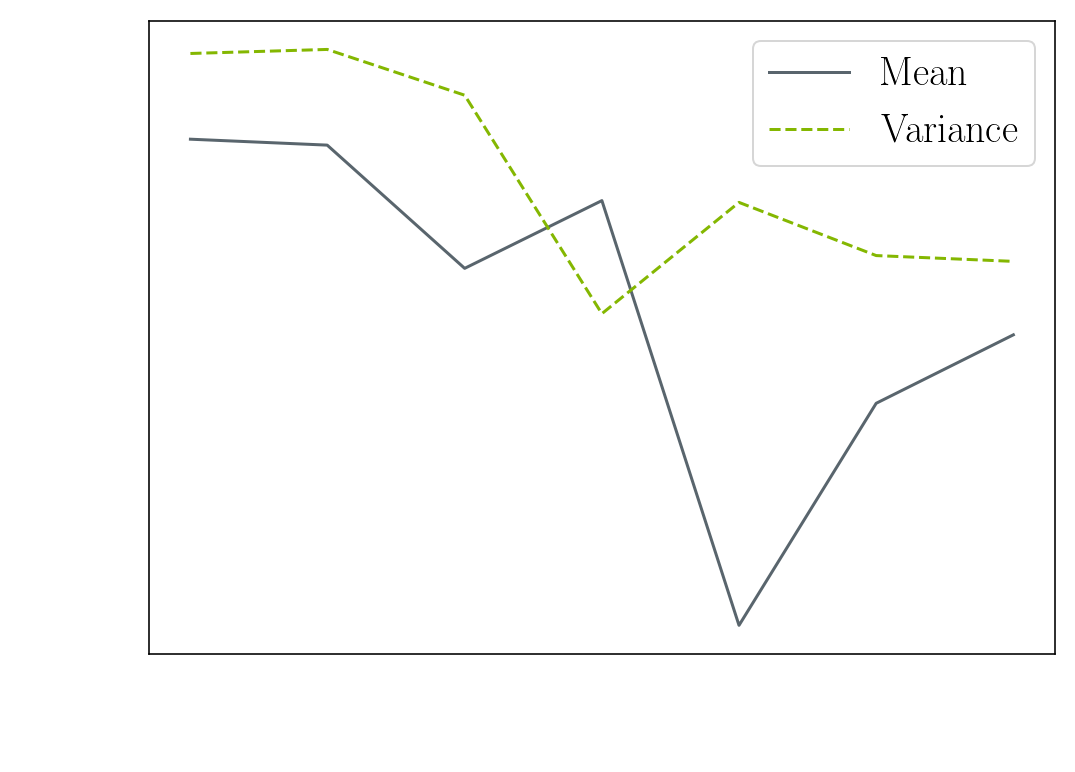

In [6]:
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

fig=plt.figure()
ax = fig.add_subplot(111, frameon=True)

plt.loglog(sizes, mean_errors, color='xkcd:slate grey', linestyle='solid')
plt.loglog(sizes, var_errors, color='xkcd:dark lime', linestyle='dashed')

plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False

plt.legend(['Mean', 'Variance'], loc='best', fontsize=20)

plt.xlabel(r"Sample Size $N$", fontsize=30, color = 'w')
plt.ylabel(r"Errors", fontsize=30, color = 'w')

plt.tick_params(axis='x', which='both', top='off', color = 'w')
plt.xticks(fontsize=16, rotation=0, color = 'w')
plt.tick_params(axis='y', which='both', right='off', color = 'w')
plt.yticks(fontsize=16, rotation=0, color = 'w')

plt.tight_layout()

fig.set_size_inches(8, 6)
#plt.rcParams['figure.dpi'] = 600

#"""
plt.show()

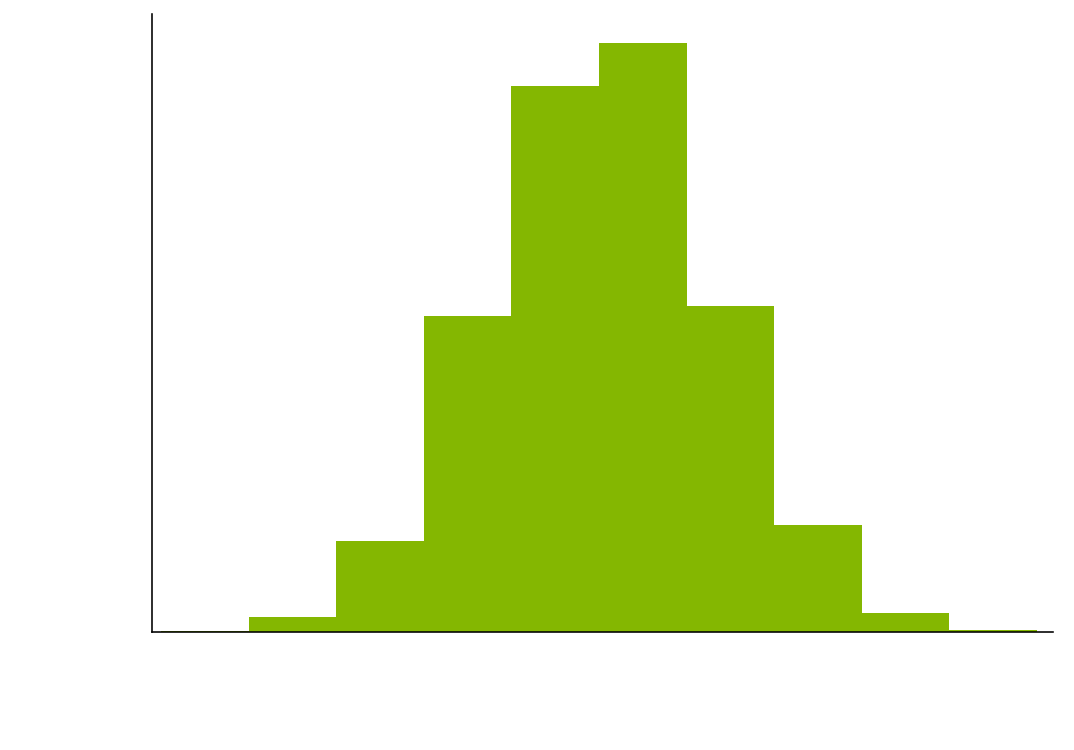

In [7]:
fig=plt.figure()
ax = fig.add_subplot(111, frameon=True)

plt.hist(q, color='xkcd:dark lime')

plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False

plt.xlabel(r"Position $q$", fontsize=30, color = 'w')
plt.ylabel(r"Number of Samples", fontsize=30, color = 'w')

plt.tick_params(axis='x', which='both', top='off', color = 'w')
plt.xticks(fontsize=16, rotation=0, color = 'w')
plt.tick_params(axis='y', which='both', right='off', color = 'w')
plt.yticks(fontsize=16, rotation=0, color = 'w')

plt.xlim([-4,4])

plt.tight_layout()

fig.set_size_inches(8, 6)
#plt.rcParams['figure.dpi'] = 600

#"""
plt.show()

Generally, it appears that HMC produces more accurate and well-behaved error curves for the key statistics of our distribution than does MH. HMC also typically tends to give rise to more symmetric histograms than MH with a maximum stepsize of $h=2\times 10^{-1}$ (but still not as symmetric as MH with $h=1$). This tells us that HMC explores the data more evenhandedly than MH: moving according to an interrupted Hamiltonian flow lets us go a bit further and prevents us from getting stuck in the ruts that pure random walks are susceptible to. 

TODO: explain where the "Markov chain" comes in here! Maybe cite Betancourt's "Geometry of HMC" paper
TODO: Emphasize that performing the Hamiltonian flow requires us to know derivatives of our target distribution. This may be difficult, ie. when our distribution is given as a black box (ie. it has been empirically determined by KDE or some other method) 